In [62]:
import os
import random
from io import BytesIO

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from transformers import (BertModel, BertTokenizer, Wav2Vec2Model,
                          Wav2Vec2Processor)
from tqdm import tqdm

In [63]:
# --------------------
# Config
# --------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 10
IMG_SIZE = 224
TEMPERATURE = 0.07
EMBED_DIM = 512
NUM_CONCEPTS = 100
MAX_TRAIN_STEPS = 10   # Set to None for full epoch
MAX_EVAL_STEPS = 5     # Set to None for full validation

In [64]:
# --------------------
# Metric storage
# --------------------
train_losses, train_accuracies, val_accuracies = [], [], []

In [65]:
# --------------------
# Transforms
# --------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [66]:
# --------------------
# Dataset preparation
# --------------------
raw_ds = load_dataset("jxie/flickr8k", split="train").select(range(1000))
train_raw, val_raw = raw_ds.select(range(800)), raw_ds.select(range(800, 1000))

class FlickrDataset(Dataset):
    """Wraps the Flickr8k HF dataset and injects simple hierarchy tags."""

    fake_labels = ["dog", "man", "child", "car", "beach", "ball", "woman", "bicycle"]
    taxonomy = {
        "animal": ["dog", "child"],
        "human": ["man", "woman"],
        "vehicle": ["car", "bicycle"],
        "environment": ["beach"],
        "object": ["ball"],
    }

    def __init__(self, hf_split):
        self.samples = hf_split

    def __len__(self):
        return len(self.samples) * 5  # each image has 5 captions

    def __getitem__(self, idx):
        s_idx, c_idx = divmod(idx, 5)
        sample = self.samples[s_idx]

        img_data = sample["image"]
        img = (
            img_data.convert("RGB")
            if hasattr(img_data, "convert")
            else Image.open(BytesIO(img_data)).convert("RGB")
        )

        caption = sample[f"caption_{c_idx}"]
        if "," in caption:
            parts = caption.split(",")
            random.shuffle(parts)
            caption = ", ".join(parts)

        label = random.choice(self.fake_labels)
        superclasses = [k for k, v in self.taxonomy.items() if label in v]
        caption = f"{caption}. Object: {label}. Hierarchy: {' > '.join(superclasses + [label])}"
        return transform(img), caption

train_ds = FlickrDataset(train_raw)
val_ds = FlickrDataset(val_raw)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [67]:
# --------------------
# Encoders & Projections
# --------------------
# Text
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
text_proj = nn.Linear(768, EMBED_DIM).to(DEVICE)

def encode_text(batch):
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        feats = bert(**inputs).last_hidden_state[:, 0]  # CLS token
    return text_proj(feats)

# Vision
resnet = models.resnet50(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(DEVICE)
vision_proj = nn.Linear(2048, EMBED_DIM).to(DEVICE)

def encode_image(batch):
    with torch.no_grad():
        feats = resnet(batch.to(DEVICE))
    return vision_proj(feats)

# Audio (optional)
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
wav2vec = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").to(DEVICE)
audio_proj = nn.Linear(wav2vec.config.hidden_size, EMBED_DIM).to(DEVICE)

def encode_audio(waveform):
    inp = processor(waveform, return_tensors="pt", sampling_rate=16000, padding=True).to(DEVICE)
    with torch.no_grad():
        feats = wav2vec(**inp).last_hidden_state.mean(dim=1)
    return audio_proj(feats)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
# --------------------
# Concept Memory
# --------------------
concept_memory = nn.Parameter(torch.randn(NUM_CONCEPTS, EMBED_DIM, device=DEVICE))

In [69]:
# --------------------
# Loss functions
# --------------------

def cosine_similarity(a, b):
    a, b = F.normalize(a, dim=-1), F.normalize(b, dim=-1)
    return a @ b.T


def contrastive_loss(img_emb, txt_emb):
    sim = cosine_similarity(img_emb, txt_emb)
    labels = torch.arange(sim.size(0), device=DEVICE)
    return 0.5 * (
        F.cross_entropy(sim / TEMPERATURE, labels)
        + F.cross_entropy(sim.T / TEMPERATURE, labels)
    )


def concept_alignment_loss(emb):
    sim = cosine_similarity(emb, concept_memory)
    return 1 - sim.max(dim=1).values.mean()


def retrieval_accuracy(img_emb, txt_emb):
    sim = cosine_similarity(img_emb, txt_emb)
    return (sim.argmax(1) == torch.arange(sim.size(0), device=DEVICE)).float().mean().item()

In [70]:
# --------------------
# Optimizer
# --------------------
optimizer = torch.optim.Adam(
    list(resnet.parameters())
    + list(vision_proj.parameters())
    + list(text_proj.parameters())
    + list(audio_proj.parameters())
    + [concept_memory],
    lr=LR,
)


In [71]:
# --------------------
# Evaluation helper
# --------------------

def evaluate(loader, max_steps=None):
    img_embs, txt_embs, steps = [], [], 0
    for imgs, caps in loader:
        if max_steps and steps >= max_steps:
            break
        img_embs.append(encode_image(imgs))
        txt_embs.append(encode_text(caps))
        steps += 1
    img_embs = torch.cat(img_embs)
    txt_embs = torch.cat(txt_embs)
    acc = retrieval_accuracy(img_embs, txt_embs)
    val_accuracies.append(acc)
    print(f"Val Acc: {acc:.4f}")

In [73]:
# --------------------
# Training
# --------------------
for epoch in range(EPOCHS):
    loss_sum = acc_sum = steps = 0
    for imgs, caps in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        if MAX_TRAIN_STEPS and steps >= MAX_TRAIN_STEPS:
            break
        img_emb = encode_image(imgs)
        txt_emb = encode_text(caps)

        loss = contrastive_loss(img_emb, txt_emb) + 0.1 * (
            concept_alignment_loss(img_emb) + concept_alignment_loss(txt_emb)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = retrieval_accuracy(img_emb, txt_emb)
        loss_sum += loss.item()
        acc_sum += acc
        steps += 1

    train_losses.append(loss_sum / steps)
    train_accuracies.append(acc_sum / steps)
    print(
        f"Epoch {epoch+1}: loss={train_losses[-1]:.4f}, train_acc={train_accuracies[-1]:.4f}"
    )
    evaluate(val_loader, MAX_EVAL_STEPS)

Epoch 1/10:   4%|▍         | 10/250 [01:03<25:33,  6.39s/it]

Epoch 1: loss=2.9487, train_acc=0.0813


Val Acc: 0.0125


Epoch 2/10:   4%|▍         | 10/250 [01:04<25:59,  6.50s/it]

Epoch 2: loss=2.8596, train_acc=0.1500


Val Acc: 0.0125


Epoch 3/10:   4%|▍         | 10/250 [01:06<26:37,  6.66s/it]

Epoch 3: loss=2.7266, train_acc=0.1938


Val Acc: 0.0375


Epoch 4/10:   4%|▍         | 10/250 [01:04<25:47,  6.45s/it]

Epoch 4: loss=2.6508, train_acc=0.2437


Val Acc: 0.0250


Epoch 5/10:   4%|▍         | 10/250 [01:04<25:46,  6.44s/it]

Epoch 5: loss=2.4978, train_acc=0.2000


Val Acc: 0.0875


Epoch 6/10:   4%|▍         | 10/250 [01:04<25:51,  6.46s/it]

Epoch 6: loss=2.3622, train_acc=0.3063


Val Acc: 0.0500


Epoch 7/10:   4%|▍         | 10/250 [01:06<26:31,  6.63s/it]

Epoch 7: loss=2.1815, train_acc=0.3063


Val Acc: 0.0625


Epoch 8/10:   4%|▍         | 10/250 [01:04<25:59,  6.50s/it]

Epoch 8: loss=2.1356, train_acc=0.3125


Val Acc: 0.1000


Epoch 9/10:   4%|▍         | 10/250 [01:03<25:23,  6.35s/it]

Epoch 9: loss=1.9983, train_acc=0.3688


Val Acc: 0.0625


Epoch 10/10:   4%|▍         | 10/250 [01:02<25:07,  6.28s/it]

Epoch 10: loss=1.9330, train_acc=0.4062


Val Acc: 0.1000


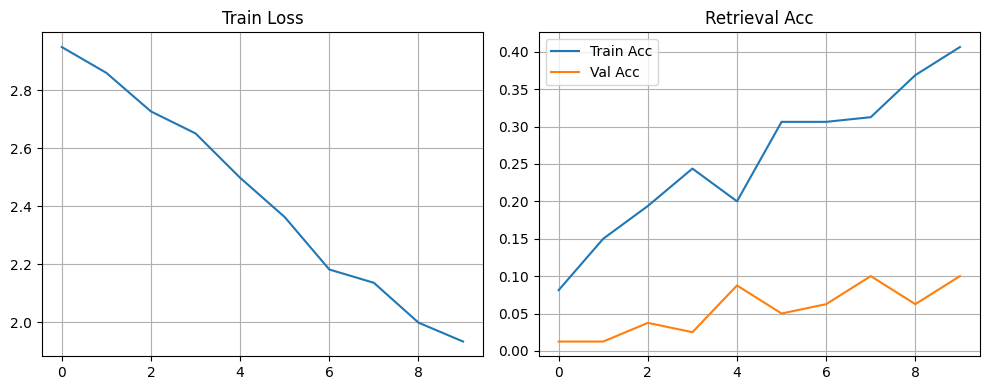

In [74]:
# --------------------
# Plot curves
# --------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss")
plt.title("Train Loss")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Retrieval Acc")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

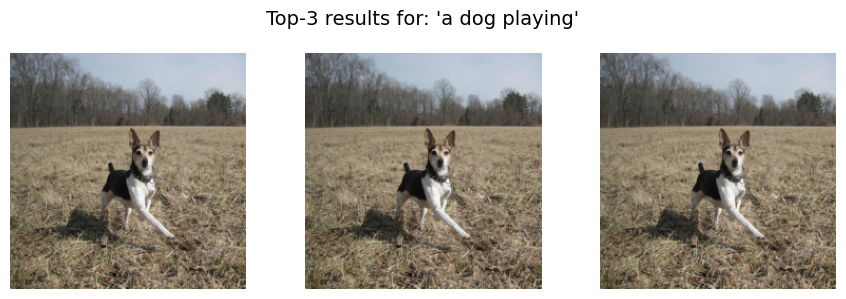

[tensor([[[0.3765, 0.3333, 0.2980,  ..., 0.6784, 0.6863, 0.6863],
          [0.3176, 0.3412, 0.3137,  ..., 0.6824, 0.6902, 0.6941],
          [0.3529, 0.3529, 0.3137,  ..., 0.6902, 0.6941, 0.6902],
          ...,
          [0.3608, 0.3059, 0.4235,  ..., 0.5608, 0.5294, 0.6902],
          [0.4039, 0.3961, 0.2980,  ..., 0.2824, 0.4275, 0.5412],
          [0.5373, 0.4902, 0.4196,  ..., 0.2745, 0.3804, 0.3804]],
 
         [[0.4196, 0.3686, 0.3176,  ..., 0.7412, 0.7490, 0.7529],
          [0.3569, 0.3765, 0.3451,  ..., 0.7451, 0.7529, 0.7608],
          [0.3686, 0.3804, 0.3490,  ..., 0.7529, 0.7569, 0.7569],
          ...,
          [0.3020, 0.2627, 0.3647,  ..., 0.5059, 0.4588, 0.6078],
          [0.3686, 0.3882, 0.2588,  ..., 0.2078, 0.3412, 0.4549],
          [0.4863, 0.4667, 0.4078,  ..., 0.2039, 0.2824, 0.2745]],
 
         [[0.4510, 0.3922, 0.3412,  ..., 0.8157, 0.8157, 0.8196],
          [0.3882, 0.4039, 0.3608,  ..., 0.8157, 0.8196, 0.8275],
          [0.4157, 0.4118, 0.3686,  ...,

In [75]:
# --------------------
# Interactive text→image retrieval with visualization
# --------------------

def find_similar_images(query, dataset, k=5):
    """Return top‑k images for a text query and display them."""
    q_emb = encode_text([query])
    scores = []
    for img, _ in dataset:
        scores.append(cosine_similarity(q_emb, encode_image(img.unsqueeze(0))).item())
    top_idx = sorted(range(len(scores)), key=lambda i: -scores[i])[:k]
    top_imgs = [dataset[i][0] for i in top_idx]

    # --- visualise ---
    n_cols = min(k, 5)
    plt.figure(figsize=(3 * n_cols, 3))
    for i, t_img in enumerate(top_imgs, 1):
        plt.subplot(1, n_cols, i)
        np_img = t_img.permute(1, 2, 0).cpu().numpy()
        plt.imshow(np_img)
        plt.axis("off")
    plt.suptitle(f"Top‑{k} results for: '{query}'", fontsize=14)
    plt.tight_layout()
    plt.show()

    return top_imgs

# Example usage (quick test)
find_similar_images("a dog playing", val_ds, k=3)